<a href="https://colab.research.google.com/github/Andreas-Lukito/Google-Play-Store-Game-Sentiment-Analysis/blob/colab/google_play_sentiment_analysis_colab_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Play Game Reviews Sentiment Analysis

## Install Libraries

In [ ]:
! pip install google_play_scraper contractions emoji googletrans gensim optuna torch matplotlib langdetect

## Import Library

In [73]:
# Common python libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import random
from typing import Union
from copy import deepcopy
from wordcloud import WordCloud
import joblib
import json
import time

# for cleaner output
from tqdm import tqdm
from IPython.display import clear_output

# Data Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# Web Scraping Libraries
from google_play_scraper import reviews

# Text preprocessing/cleaning Libraries
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re # regex
import string
import contractions
import emoji
from googletrans import Translator
from langdetect import detect

# Text Embedding
## TF-IDF libraries
from sklearn.feature_extraction.text import TfidfVectorizer

## Word2Vec Libraries
import gensim
from gensim.models import Word2Vec

# Models
## Machine Learning Models
from xgboost import XGBClassifier

## Machine Learning Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

## Deep Learning Libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

## Deep Learning Hyperparameter Tuning
import optuna
from optuna.exceptions import TrialPruned
from optuna.trial import TrialState

# Model Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Download nltk dependencies
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Device Selection

In [74]:
# Detect available device
if torch.cuda.is_available():
    # check if ROCm backend is active
    if torch.version.hip is not None:
        backend = "ROCm"
    else:
        backend = "CUDA"

    device = torch.device("cuda")
    print(f"PyTorch is using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Backend: {backend}")
else:
    device = torch.device("cpu")
    print("PyTorch is not using GPU — running on CPU")

PyTorch is using GPU: NVIDIA L4
Backend: CUDA


## Project Path

In [75]:
from google.colab import drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/Google_play_sentiment_analysis"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Web Scraping

we will get the reviews of `among us` game

link : https://play.google.com/store/apps/details?id=com.innersloth.spacemafia&hl=en
appid: com.innersloth.spacemafia
the appid is taken from the end of the link

In [76]:
# for each game, we would pull 1000 reviews with 5, 4, 3, 2, 1 to ensure data balance.
# since all the games has more than 1M reviews it is safe to gather 5000 data per game.

# extract reviews function
def get_game_reviews(app_id_list: list, n_reviews: int = 1000, language: str  = "en", country: str = "us", score_filter: Union[list, int] = [5, 4, 3, 2, 1]) -> DataFrame:

    def extract_reviews(app_id: str, n_reviews: int = 1000, language: str  = "en", country: str = "us", score_filter: int = 5):# -> List[dict]:
        # The "reviews" function below returns "result" (a list of reviews)
        # and a "continuation_token" for fetching the next batch (not used here).
        result, _ = reviews(app_id,
                            lang = language,
                            country = country,
                            count = n_reviews,
                            filter_score_with = score_filter
                        )

        return result

    # handle the score filter if the user only inputs 1 number
    if isinstance(score_filter, int):
        score_filter = [score_filter]

    # Create an empty list to store all the reviews
    all_reviews = []

    for app_id in tqdm(app_id_list, desc="Extracting Reviews ...", unit="app"):
        clear_output(wait=True)
        print(f"Fetching Data for {app_id}")

        for score in score_filter:
            game_reviews = extract_reviews(app_id, n_reviews, score_filter=score)
            for single_review in game_reviews:
                single_review["app_id"] = app_id
                all_reviews.append(single_review)

    clear_output(wait=True)
    print(f"Done Extracting Reviews. Total rows: {len(all_reviews)}")
    return pd.DataFrame(all_reviews)

In [77]:
# caching the dataset
playstore_review_data_path = "./cache/dataset"
os.makedirs(playstore_review_data_path, exist_ok=True) # if the directory exist no need to make

# The app list that we want to get the review of
# note: you can add more app id's

app_id_list = [
    "com.innersloth.spacemafia"
]

n_reviews = 200 # since there are 5 ratings it would be 200 * 5 = 1000 data

cached_file = os.path.join(playstore_review_data_path, "reviews_data.csv")

get_new_data = False

# We will cache the data so that it will load faster
if os.path.exists(cached_file) and not get_new_data:
    print("Loading cached dataset...")
    review_df = pd.read_csv(cached_file)
    print("Cached dataset loaded")

elif os.path.exists(cached_file) and get_new_data:
    print("Overwriting old data and caching new data...")
    review_df = get_game_reviews(app_id_list, n_reviews)
    review_df.to_csv(cached_file, index=False)

else:
    print("Creating and caching dataset...")
    review_df = get_game_reviews(app_id_list, n_reviews)
    review_df.to_csv(cached_file, index=False)

Loading cached dataset...
Cached dataset loaded


In [78]:
review_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app_id
0,039ebe83-b35e-430d-8057-4536d93b4afd,Puja Dev das,https://play-lh.googleusercontent.com/a/ACg8oc...,I love this game and I played it many times,5,0,NaN,2025-11-06 13:18:23,NaN,NaN,NaN,com.innersloth.spacemafia
1,61858394-8e06-4d41-8d37-36e1d37bea17,آرمین آراسته,https://play-lh.googleusercontent.com/a-/ALV-U...,good,5,0,NaN,2025-11-06 12:24:09,NaN,NaN,NaN,com.innersloth.spacemafia
2,dd6287d6-830c-46bb-b99d-0d90dbe3f485,arthur tarellari,https://play-lh.googleusercontent.com/a/ACg8oc...,it is so fun,5,0,2025.10.14,2025-11-06 12:03:05,NaN,NaN,2025.10.14,com.innersloth.spacemafia
3,1b72ac18-d064-4958-a6f5-0a83d5ea6290,Manisha ben Patel,https://play-lh.googleusercontent.com/a/ACg8oc...,good,5,0,2025.10.14,2025-11-06 11:57:09,NaN,NaN,2025.10.14,com.innersloth.spacemafia
4,8b9158d9-fe27-4186-8485-7e98e79d34fe,Mohammad Asif,https://play-lh.googleusercontent.com/a-/ALV-U...,I like how everything got free and its cool an...,5,0,2024.3.5,2025-11-06 11:44:32,NaN,NaN,2024.3.5,com.innersloth.spacemafia
...,...,...,...,...,...,...,...,...,...,...,...,...
995,64362782-d3b0-4a7e-a964-af9818799aba,Enoch Hepp,https://play-lh.googleusercontent.com/a/ACg8oc...,help,1,0,NaN,2025-10-30 00:00:49,NaN,NaN,NaN,com.innersloth.spacemafia
996,3da25b1f-3e0f-4664-86d6-8f4a297d6371,mmabatho khomo,https://play-lh.googleusercontent.com/a-/ALV-U...,Waiting for the loading screen,1,0,2025.10.14,2025-10-29 22:04:46,NaN,NaN,2025.10.14,com.innersloth.spacemafia
997,2c875b30-c7b4-4746-b986-aacbfeb3162b,Micayla,https://play-lh.googleusercontent.com/a/ACg8oc...,Game bans you from joining a game for 120 minu...,1,0,2025.9.9,2025-10-29 20:48:31,apologies about the disconnection issue :/ can...,2025-10-29 21:21:05,2025.9.9,com.innersloth.spacemafia
998,a5b3b59f-c614-4ffa-b793-b4b8202f7c35,Da Boss K.C,https://play-lh.googleusercontent.com/a/ACg8oc...,"absolutely loved this game when it peaked, tri...",1,1,NaN,2025-10-29 20:20:44,"no worries, just send an email to support@inne...",2025-10-29 21:21:05,NaN,com.innersloth.spacemafia


## EDA

#### Word Cloud

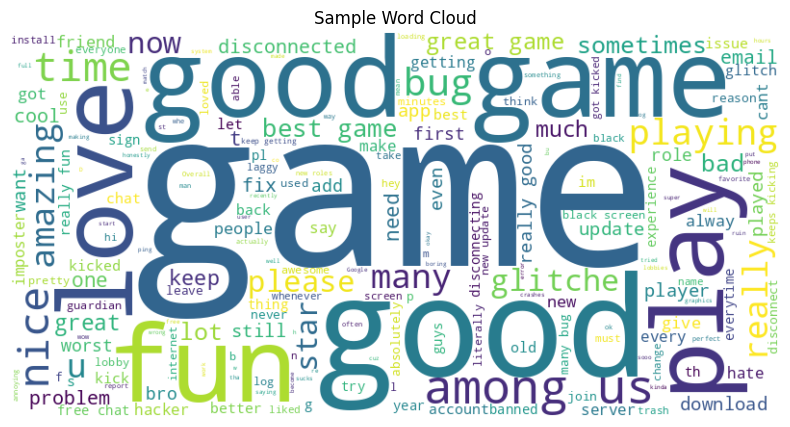

In [79]:
text = review_df["content"].to_string()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sample Word Cloud")
plt.show()

The word cloud reveals that the most frequently used terms in the reviews include “good game,” “love,” “fun,” “nice,” and “best game.” This indicates that the majority of players express <b style="color:green;">positive sentiments</b> toward the game. Despite occasional mentions of bugs, errors, or disconnections, these positive keywords suggest that players generally enjoy the gameplay experience and hold a favorable opinion of the game overall.

#### Data Plotting Function

In [80]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data.

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")

    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")

    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

#### Number of English Reviews

In [81]:
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

review_df["is_english"] = review_df["content"].apply(is_english)

In [82]:
print(f"Percentage of english reviews: {np.mean(review_df['is_english'] == True)*100:.2f}%")
print(f"Percentage of non-english reviews: {np.mean(review_df['is_english'] == False)*100:.2f}%")

Percentage of english reviews: 85.20%
Percentage of non-english reviews: 14.80%


### Score Distribution (without dropping the non-english reviews)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

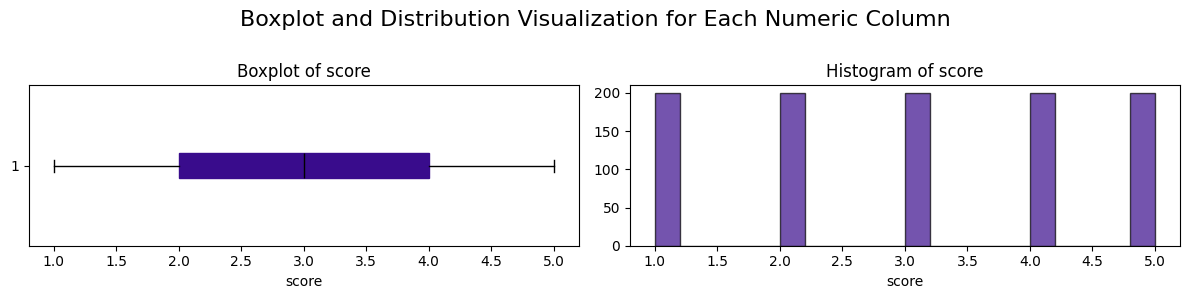

In [83]:
numeric_dist_plot(pd.DataFrame(review_df["score"]))

### Score Distribution (with dripping the non-english reviews)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

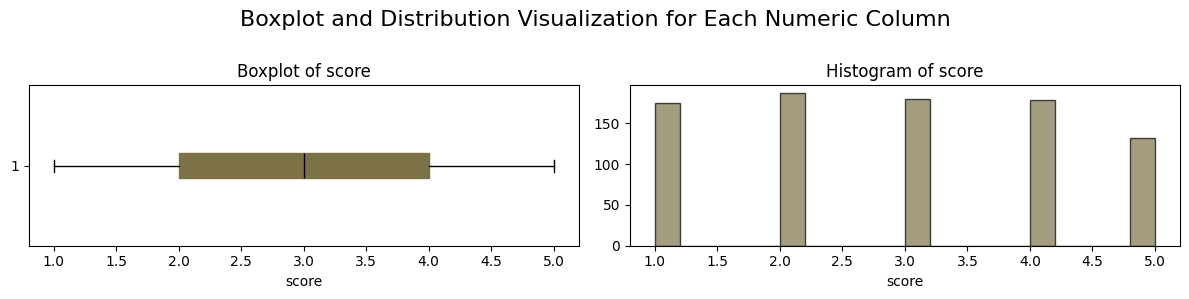

In [84]:
numeric_dist_plot(pd.DataFrame(review_df[review_df["is_english"] == True]["score"]))

EDA Summary:

Out of 1,000 reviews, around 86.3% are in English. The remaining ~13.7% are non-English, emoji/symbol-only, or misclassified by langdetect due to being very short (e.g., "good game", "fun").

| Method      | Pros                                         | Cons                                  |
| ----------- | -------------------------------------------- | ------------------------------------- |
| Translating | Preserves most reviews, maintains balance   | Some mistranslation/noise             |
| Dropping    | Only clean English reviews                  | Lose ~13.7% of data, may skew ratings  |

Key Findings:
- Dropping non-English reviews <b style="color:green">did not produce major skew</b> in the ratings distribution. which disproves the previous hypothesis.
- Rating 5 is <b style="color:red">slightly underrepresented</b> (~140 reviews) while ratings 1–4 have >150 each.
- Dropping reviews <b style="color:red">reduces</b> the dataset from 1,000 to ~863 reviews. which is crucial since training a model requires a good amount of data and currently having around 200 data per review would not be beneficial.

Conclusion:
- To preserve dataset balance, all non-English reviews will be translated to English.

In [85]:
review_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app_id,is_english
0,039ebe83-b35e-430d-8057-4536d93b4afd,Puja Dev das,https://play-lh.googleusercontent.com/a/ACg8oc...,I love this game and I played it many times,5,0,NaN,2025-11-06 13:18:23,NaN,NaN,NaN,com.innersloth.spacemafia,True
1,61858394-8e06-4d41-8d37-36e1d37bea17,آرمین آراسته,https://play-lh.googleusercontent.com/a-/ALV-U...,good,5,0,NaN,2025-11-06 12:24:09,NaN,NaN,NaN,com.innersloth.spacemafia,False
2,dd6287d6-830c-46bb-b99d-0d90dbe3f485,arthur tarellari,https://play-lh.googleusercontent.com/a/ACg8oc...,it is so fun,5,0,2025.10.14,2025-11-06 12:03:05,NaN,NaN,2025.10.14,com.innersloth.spacemafia,True
3,1b72ac18-d064-4958-a6f5-0a83d5ea6290,Manisha ben Patel,https://play-lh.googleusercontent.com/a/ACg8oc...,good,5,0,2025.10.14,2025-11-06 11:57:09,NaN,NaN,2025.10.14,com.innersloth.spacemafia,False
4,8b9158d9-fe27-4186-8485-7e98e79d34fe,Mohammad Asif,https://play-lh.googleusercontent.com/a-/ALV-U...,I like how everything got free and its cool an...,5,0,2024.3.5,2025-11-06 11:44:32,NaN,NaN,2024.3.5,com.innersloth.spacemafia,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,64362782-d3b0-4a7e-a964-af9818799aba,Enoch Hepp,https://play-lh.googleusercontent.com/a/ACg8oc...,help,1,0,NaN,2025-10-30 00:00:49,NaN,NaN,NaN,com.innersloth.spacemafia,False
996,3da25b1f-3e0f-4664-86d6-8f4a297d6371,mmabatho khomo,https://play-lh.googleusercontent.com/a-/ALV-U...,Waiting for the loading screen,1,0,2025.10.14,2025-10-29 22:04:46,NaN,NaN,2025.10.14,com.innersloth.spacemafia,True
997,2c875b30-c7b4-4746-b986-aacbfeb3162b,Micayla,https://play-lh.googleusercontent.com/a/ACg8oc...,Game bans you from joining a game for 120 minu...,1,0,2025.9.9,2025-10-29 20:48:31,apologies about the disconnection issue :/ can...,2025-10-29 21:21:05,2025.9.9,com.innersloth.spacemafia,True
998,a5b3b59f-c614-4ffa-b793-b4b8202f7c35,Da Boss K.C,https://play-lh.googleusercontent.com/a/ACg8oc...,"absolutely loved this game when it peaked, tri...",1,1,NaN,2025-10-29 20:20:44,"no worries, just send an email to support@inne...",2025-10-29 21:21:05,NaN,com.innersloth.spacemafia,True


## Text Cleaning

### Text Cleaning Function

In [86]:
def clean_text(text: str, language: str='english', tokenize: bool = False, remove_stop_words: bool = False, stem_words: bool = False, remove_url: bool = False, remove_emojis: str = "convert", expand_abbreviations: bool=False):
    """
    #### Description:
    This function is to clean the text from stopwords, punctuation and return a clean text for further analysis

    Args:
        text (str):
            The dataframe containing the text data

        language (str):
            This are the available languages for the stopwords:
            - "catalan"
            - "czech"
            - "german"
            - "greek"
            - "english"
            - "spanish"
            - "finnish"
            - "french"
            - "hungarian"
            - "icelandic"
            - "italian"
            - "latvian"
            - "dutch"
            - "polish"
            - "portuguese"
            - "romanian"
            - "russian"
            - "slovak"
            - "slovenian"
            - "swedish"
            - "tamil"

        tokenize (bool):
            True = return tokenized data
            False = return untokenized data

        remove_stop_words (bool):
            True = remove stop words
            False = do not remove stop words

        stem_words (bool):
            True = get the base words (i.e. spraying -> spray)
            False = leave the words as is

        remove_url (bool):
            True = Remove the url in the text
            False = leave the text as is

        remove_emojis (str):
            "remove" = Removes the emoji in text
            "convert = converts emoji to text (e.g. ❤️ -> :red_heart:)
            "keep" = keeps the emoji as is

        expand_abbreviations (bool):
            True = Expand abbreviations (e.g. brb -> "be right back")
            False = Keep the abbriviations as is
    """

    # slang dictionary
    slang_dict = {
        "brb": "be right back",
        "afk": "away from keyboard",
        "gg": "good game",
        "ggwp": "good game well played",
        "lol": "laughing out loud",
        "idk": "I do not know",
        "imo": "in my opinion",
        "lmao": "laughing my ass off",
        "lmfao": "laughing fucking my ass off",
        "sus": "suspicious",
        "rekt": "wrecked",
        "noob": "new player",
        "af": "as hell",
        "wtf": "what the fuck",
        "wth": "what the heck",
        "omg": "oh my god",
        "ty": "thank you",
        "plz": "please",
        "pls": "please",
        "u": "you",
        "r": "are",
        "thx": "thanks",
        "fr": "for real",
        "til": "today i learned",
        "asap": "as soon as possible",
        "g2g": "got to go",
        "gtg": "got to go",
        "nc": "nice",
        "fyi": "for your information",
        "ttyl": "talk to you later",
        "fb": "facebook",
        "msg": "message",
        "hifw": "how i feel when",
        "tfw": "the feeling when",
        "mfw": "my face when",
        "mrw": "my reaction when",
        "ifyp": "i feel your pain",
        "tntl": "trying not to laugh",
        "jk": "just kidding",
        "idc": "i dont care",
        "ily": "i love you",
        "imu": "i miss you",
        "zzz": "sleeping, bored, tired",
        "ftw": "for the win",
        "tbh": "to be honest",
        "ftl": "for the loss",
        "smh": "shaking my head",
        "srsly": "seriously",
        "afaik": "as far as i know",
        "dm": "direct message",
        "tldr": "too long didnt read",
        "irl": "in real life",
        "gl": "goodluck",
        "ruok": "are you ok",
        "w": "win"
    }

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words(language))

    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s)]

    def remove_special_characters(text):
        # keep letters, numbers, underscores, colons (for demojized emojis)
        text = re.sub('[^a-zA-Z0-9_]', ' ', text)
        text = re.sub('\s+', ' ', text)
        return text

    def stem_text(tokens):
        return [stemmer.stem(t) for t in tokens]

    def remove_stopwords_func(tokens):
        return [w for w in tokens if w not in stop_words]

    def remove_url_func(text):
        return re.sub(r'https?://\S+|www\.\S+', '', text)

    def expand_slang(text):
        words = text.split()
        return " ".join([slang_dict.get(w.lower(), w) for w in words])

    # Clean process
    text = contractions.fix(text)                        # fixing contraction

    text = text.strip().lower()                          # lowercase + trim

    if remove_url:
        text = remove_url_func(text)                     # remove url

    # Handle emojis
    if remove_emojis.lower() == "remove":
        text = remove_special_characters(text)  # removes emojis

    elif remove_emojis.lower() == "convert":
        text = emoji.demojize(text, language="en")  # e.g.,  -> ❤️ -> :red_heart:

    elif remove_emojis.lower() == "keep":
        pass

    if expand_abbreviations:
        text = remove_special_characters(text)   # <--- clean before slang expansion
        text = expand_slang(text)

    text = remove_special_characters(text)               # Remove other special characters (but preserve converted emojis with underscores)

    tokens = tokenize_text(text)                         # tokenize words

    if remove_stop_words:
        tokens = remove_stopwords_func(tokens)           # remove stopwords

    if stem_words:
        tokens = stem_text(tokens)                       # stemming

    if tokenize:
        return tokens                                    # return as tokens
    else:
        return " ".join(tokens)                          # return as string

<>:128: SyntaxWarning: invalid escape sequence '\s'
<>:128: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1474496423.py:128: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


### Text Translation Function

In [87]:


# review_df has a column "content" with reviews
async def translate_reviews(df: pd.DataFrame, text_col: str = "content", target_lang: str = 'en') -> DataFrame:
    # get the translator
    translator = Translator()

    # define async function
    async def translate_text(text):
        result = await translator.translate(text, dest=target_lang)
        return result.text

    translated_texts = []

    for text in tqdm(df[text_col], desc="Translating Reviews...", unit="data"):
        try:
            translated = await translate_text(text)
        except Exception as e:
            print(f"Translation failed: {e}")
            translated = text  # fallback: keep original
        translated_texts.append(translated)

    df[text_col + "_en"] = translated_texts
    return df

### Cache the Translated Dataset For Faster Loading

In [88]:
# caching the dataset
playstore_review_data_path = os.path.join(project_path,"cache/dataset")
os.makedirs(playstore_review_data_path, exist_ok=True) # if the directory exist no need to make

cached_file = os.path.join(playstore_review_data_path, "reviews_data_translated.csv")

get_new_data = False

# We will cache the data so that it will load faster
if os.path.exists(cached_file) and not get_new_data:
    print("Loading cached dataset...")
    review_df = pd.read_csv(cached_file)
    print("Cached dataset loaded")

elif os.path.exists(cached_file) and get_new_data:
    print("Overwriting old data and caching new data...")
    review_df = await translate_reviews(review_df, text_col="content")
    review_df.to_csv(cached_file, index=False)

else:
    print("Creating and caching dataset...")
    review_df = await translate_reviews(review_df, text_col="content")
    review_df.to_csv(cached_file, index=False)

Loading cached dataset...
Cached dataset loaded


In [89]:
review_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app_id,is_english,content_en
0,ba615643-ffde-40ef-a45d-1fd893a1bba1,Ridwan Hossain,https://play-lh.googleusercontent.com/a-/ALV-U...,I love it 💘,5,0,2025.10.14,2025-11-05 15:19:40,NaN,NaN,2025.10.14,com.innersloth.spacemafia,False,I love it 💘
1,174dfadb-dd79-4c15-ae39-af596580b7b2,Mark Edwards,https://play-lh.googleusercontent.com/a-/ALV-U...,good game EVERYONE has too play,5,0,2025.10.14,2025-11-05 15:06:34,NaN,NaN,2025.10.14,com.innersloth.spacemafia,False,good game EVERYONE has too play
2,dd0692b5-baef-45de-89b7-465c592fab19,Yobu Abel,https://play-lh.googleusercontent.com/a-/ALV-U...,good game just need more cosmetics and cosmic ...,5,0,2025.10.14,2025-11-05 14:25:54,NaN,NaN,2025.10.14,com.innersloth.spacemafia,True,good game just need more cosmetics and cosmic ...
3,9b641f61-5679-4133-97ad-c678741aa9ee,Namami Solanki,https://play-lh.googleusercontent.com/a-/ALV-U...,I love you among us . Please make me imposter,5,0,NaN,2025-11-05 14:23:11,NaN,NaN,NaN,com.innersloth.spacemafia,True,I love you among us . Please make me imposter
4,bac7d3ec-cfba-4f34-9409-b49bcd7381e5,Dr. Amol Mane,https://play-lh.googleusercontent.com/a/ACg8oc...,very nice game 👌✨👍❤️,5,0,NaN,2025-11-05 13:56:56,NaN,NaN,NaN,com.innersloth.spacemafia,True,very nice game 👌✨👍❤️
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,163fe0fc-46db-4db6-893e-9599fb6ffaf1,R Q,https://play-lh.googleusercontent.com/a-/ALV-U...,What do we have for this to be a problem in ou...,1,1,2020.9.9,2025-10-29 09:10:17,:V,2025-05-14 21:15:11,2020.9.9,com.innersloth.spacemafia,True,What do we have for this to be a problem in ou...
996,fd769d16-9eab-4b50-9e24-c71748c2b95f,Izyk Baltazar,https://play-lh.googleusercontent.com/a/ACg8oc...,game used to be so good to many changes doesn'...,1,0,NaN,2025-10-29 08:02:36,tell us more about your experience at support@...,2025-10-29 22:47:48,NaN,com.innersloth.spacemafia,True,game used to be so good to many changes doesn'...
997,d11b3303-11d9-4d38-9111-58116ad63db9,Keira Marlow,https://play-lh.googleusercontent.com/a-/ALV-U...,"so I actually love the game, however I'm in th...",1,0,2025.10.14,2025-10-29 07:24:31,apologies about the disconnection issue :/ can...,2025-10-29 22:47:47,2025.10.14,com.innersloth.spacemafia,True,"so I actually love the game, however I'm in th..."
998,a784b111-f65f-4155-b3dd-833555ec063b,Myself__Sandipan,https://play-lh.googleusercontent.com/a-/ALV-U...,too much 💔😔 server problem please 😞 fix this bug,1,0,NaN,2025-10-29 02:53:26,hey crewmate! please restart your app or go to...,2025-10-29 04:12:23,NaN,com.innersloth.spacemafia,True,too much 💔😔 server problem please 😞 fix this bug


### Check if there is Missing Values in the Translated Dataset

In [90]:
review_df.isna().sum()

,0
reviewId,0
userName,0
userImage,0
content,1
score,0
thumbsUpCount,0
reviewCreatedVersion,441
at,0
replyContent,866
repliedAt,866


since there is a single missing value at `content` column where the user didn't write anything when giving a rating, we would drop it.

In [91]:
# drop the missing value
# Drop reviews with missing content
review_df = review_df.dropna(subset=["content"])

In [92]:
# check for missing values again
review_df.isna().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,440
at,0
replyContent,865
repliedAt,865


## Preprocessing

### Split the Data to Train, Test, and Validation

In [93]:
test_size = 0.10
val_size = 0.10

# Splitting the data into train and temp (which will be further split into validation and test)
train_df, test_df = train_test_split(review_df, test_size=test_size, stratify=review_df['score'], random_state=42) #stratify is used to ensure that the same proportion of each class is present in both the training and test sets

# Splitting train into validation and test sets
train_df, val_df = train_test_split(train_df, test_size=val_size, stratify=train_df['score'], random_state=42)

In [94]:
# get the x values
x_train = deepcopy(train_df)
x_test = deepcopy(test_df)
x_val = deepcopy(val_df)

### Encoding the y_data

In [95]:
ordinal_encoder = OrdinalEncoder(categories=[['1','2','3','4','5']])

y_train = ordinal_encoder.fit_transform(train_df[["score"]]).ravel().astype(int)
y_test = ordinal_encoder.transform(test_df[["score"]]).ravel().astype(int)
y_val = ordinal_encoder.transform(val_df[["score"]]).ravel().astype(int)


#### Clean the text Before Passing it to TF-IDF and Word2Vec

In [96]:
x_train["cleaned_text"] = x_train["content_en"].apply(
    lambda x: clean_text(
        text = x,
        language="english",
        tokenize=False,
        remove_stop_words= True,
        remove_emojis="convert",
        expand_abbreviations=True
    )
)
x_test["cleaned_text"] = x_test["content_en"].apply(
    lambda x: clean_text(
        text = x,
        language="english",
        tokenize=False,
        remove_stop_words= True,
        remove_emojis="convert",
        expand_abbreviations=True
    )
)
x_val["cleaned_text"] = x_val["content_en"].apply(
    lambda x: clean_text(
        text = x,
        language="english",
        tokenize=False,
        remove_stop_words= True,
        remove_emojis="convert",
        expand_abbreviations=True
    )
)

## TF-IDF

### Prepare data for TF-IDF

In [97]:
x_train

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app_id,is_english,content_en,cleaned_text
739,b0dbe6ba-3b75-480c-a87a-9c0351410e32,Jeziah Myrphet,https://play-lh.googleusercontent.com/a-/ALV-U...,disconnecting all the time,2,0,NaN,2025-10-09 20:53:35,NaN,NaN,NaN,com.innersloth.spacemafia,True,disconnecting all the time,disconnecting time
647,df2ec5ac-c08b-4979-865d-09db0a46f7ae,Azazel Nights,https://play-lh.googleusercontent.com/a/ACg8oc...,good game but the 6 ping bug really ruins the ...,2,0,NaN,2025-10-26 13:42:22,NaN,NaN,NaN,com.innersloth.spacemafia,True,good game but the 6 ping bug really ruins the ...,good game 6 ping bug really ruins whole experi...
459,dc28e78b-1b41-4044-8415-cfd259b0973b,Akshay Rawat,https://play-lh.googleusercontent.com/a-/ALV-U...,good is great but the friends system here is t...,3,0,NaN,2025-10-29 17:41:29,NaN,NaN,NaN,com.innersloth.spacemafia,True,good is great but the friends system here is t...,good great friends system trash would even kno...
421,f353c475-bbda-4b49-aefd-9896acc2bfba,Richard Glisson,https://play-lh.googleusercontent.com/a-/ALV-U...,game is cool but the players TOIXC SO TOIXC TH...,3,0,2025.10.14,2025-11-03 03:07:22,NaN,NaN,2025.10.14,com.innersloth.spacemafia,True,game is cool but the players TOIXC SO TOIXC TH...,game cool players toixc toixc made snap nice l...
294,8cc61dad-2230-44d7-9711-8d087e327ff6,Asiya Firdose,https://play-lh.googleusercontent.com/a-/ALV-U...,funny 😁 😂 😀,4,0,NaN,2025-10-29 19:30:52,NaN,NaN,NaN,com.innersloth.spacemafia,False,funny 😁 😂 😀,funny beaming_face_with_smiling_eyes face_with...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2f22114a-1485-4f1f-891d-64c66a928bb9,Uuganbayar Icegod,https://play-lh.googleusercontent.com/a/ACg8oc...,my favourite game,5,0,NaN,2025-11-02 16:34:16,NaN,NaN,NaN,com.innersloth.spacemafia,True,my favourite game,favourite game
410,00b6fbd7-9eb4-40bb-a2e6-a81d03c6bdef,Anje lika,https://play-lh.googleusercontent.com/a-/ALV-U...,Not everyone have strong wifi network...so ple...,3,0,NaN,2025-11-04 10:25:16,NaN,NaN,NaN,com.innersloth.spacemafia,True,Not everyone have strong wifi network...so ple...,everyone strong wifi network please us favour ...
745,29b78f18-0ab1-4245-aeac-d541e348e3ef,haeja kerb,https://play-lh.googleusercontent.com/a-/ALV-U...,THEY DIDNT SEND ME THE EMAIL FOR PARENTS PERMI...,2,0,2025.9.9.1,2025-10-09 09:23:27,NaN,NaN,2025.9.9.1,com.innersloth.spacemafia,True,THEY DIDNT SEND ME THE EMAIL FOR PARENTS PERMI...,send email parents permission 2 days already y...
481,87056e28-8bfc-48fd-bf5b-3317c6d39ccf,Naruka Gaming,https://play-lh.googleusercontent.com/a-/ALV-U...,great but sometimes it just glitch like second...,3,0,2025.10.14,2025-10-26 13:51:20,NaN,NaN,2025.10.14,com.innersloth.spacemafia,True,great but sometimes it just glitch like second...,great sometimes glitch like second go playing ...


In [98]:
# get the cleaned text only
X_train_tfidf = x_train["cleaned_text"]
X_test_tfidf = x_test["cleaned_text"]
X_val_tfidf = x_val["cleaned_text"]

### Create TF-IDF Vectors

In [99]:
# pass the cleaned text to the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100000)  # you can change this limit
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tfidf)
X_test_tfidf = tfidf_vectorizer.transform(X_test_tfidf)
X_val_tfidf = tfidf_vectorizer.transform(X_val_tfidf)

In [100]:
print("Vocabulary size:", len(tfidf_vectorizer.get_feature_names_out()))
print("tfidf shape (train):", X_train_tfidf.shape)
print("tfidf shape (test):", X_test_tfidf.shape)
print("tfidf shape (val):", X_val_tfidf.shape)

Vocabulary size: 2134
tfidf shape (train): (809, 2134)
tfidf shape (test): (100, 2134)
tfidf shape (val): (90, 2134)


## Word2Vec

#### Prepare Data for Word2Vec

In [101]:
w2v_x_train = deepcopy(pd.DataFrame(x_train))
w2v_x_test = deepcopy(pd.DataFrame(x_test))
w2v_x_val = deepcopy(pd.DataFrame(x_val))
w2v_x_train


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app_id,is_english,content_en,cleaned_text
739,b0dbe6ba-3b75-480c-a87a-9c0351410e32,Jeziah Myrphet,https://play-lh.googleusercontent.com/a-/ALV-U...,disconnecting all the time,2,0,NaN,2025-10-09 20:53:35,NaN,NaN,NaN,com.innersloth.spacemafia,True,disconnecting all the time,disconnecting time
647,df2ec5ac-c08b-4979-865d-09db0a46f7ae,Azazel Nights,https://play-lh.googleusercontent.com/a/ACg8oc...,good game but the 6 ping bug really ruins the ...,2,0,NaN,2025-10-26 13:42:22,NaN,NaN,NaN,com.innersloth.spacemafia,True,good game but the 6 ping bug really ruins the ...,good game 6 ping bug really ruins whole experi...
459,dc28e78b-1b41-4044-8415-cfd259b0973b,Akshay Rawat,https://play-lh.googleusercontent.com/a-/ALV-U...,good is great but the friends system here is t...,3,0,NaN,2025-10-29 17:41:29,NaN,NaN,NaN,com.innersloth.spacemafia,True,good is great but the friends system here is t...,good great friends system trash would even kno...
421,f353c475-bbda-4b49-aefd-9896acc2bfba,Richard Glisson,https://play-lh.googleusercontent.com/a-/ALV-U...,game is cool but the players TOIXC SO TOIXC TH...,3,0,2025.10.14,2025-11-03 03:07:22,NaN,NaN,2025.10.14,com.innersloth.spacemafia,True,game is cool but the players TOIXC SO TOIXC TH...,game cool players toixc toixc made snap nice l...
294,8cc61dad-2230-44d7-9711-8d087e327ff6,Asiya Firdose,https://play-lh.googleusercontent.com/a-/ALV-U...,funny 😁 😂 😀,4,0,NaN,2025-10-29 19:30:52,NaN,NaN,NaN,com.innersloth.spacemafia,False,funny 😁 😂 😀,funny beaming_face_with_smiling_eyes face_with...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2f22114a-1485-4f1f-891d-64c66a928bb9,Uuganbayar Icegod,https://play-lh.googleusercontent.com/a/ACg8oc...,my favourite game,5,0,NaN,2025-11-02 16:34:16,NaN,NaN,NaN,com.innersloth.spacemafia,True,my favourite game,favourite game
410,00b6fbd7-9eb4-40bb-a2e6-a81d03c6bdef,Anje lika,https://play-lh.googleusercontent.com/a-/ALV-U...,Not everyone have strong wifi network...so ple...,3,0,NaN,2025-11-04 10:25:16,NaN,NaN,NaN,com.innersloth.spacemafia,True,Not everyone have strong wifi network...so ple...,everyone strong wifi network please us favour ...
745,29b78f18-0ab1-4245-aeac-d541e348e3ef,haeja kerb,https://play-lh.googleusercontent.com/a-/ALV-U...,THEY DIDNT SEND ME THE EMAIL FOR PARENTS PERMI...,2,0,2025.9.9.1,2025-10-09 09:23:27,NaN,NaN,2025.9.9.1,com.innersloth.spacemafia,True,THEY DIDNT SEND ME THE EMAIL FOR PARENTS PERMI...,send email parents permission 2 days already y...
481,87056e28-8bfc-48fd-bf5b-3317c6d39ccf,Naruka Gaming,https://play-lh.googleusercontent.com/a-/ALV-U...,great but sometimes it just glitch like second...,3,0,2025.10.14,2025-10-26 13:51:20,NaN,NaN,2025.10.14,com.innersloth.spacemafia,True,great but sometimes it just glitch like second...,great sometimes glitch like second go playing ...


In [102]:
w2v_x_train["tokenized"] = w2v_x_train["cleaned_text"].apply(
    lambda x: clean_text(
        text=x,
        language="english",
        tokenize=True,
        remove_stop_words=True,
        remove_url=True
    )
)
w2v_x_test["tokenized"] = w2v_x_test["cleaned_text"].apply(
    lambda x: clean_text(
        text=x,
        language="english",
        tokenize=True,
        remove_stop_words=True,
        remove_url=True
    )
)
w2v_x_val["tokenized"] = w2v_x_val["cleaned_text"].apply(
    lambda x: clean_text(
        text=x,
        language="english",
        tokenize=True,
        remove_stop_words=True,
        remove_url=True
    )
)



#### Create Word2Vec Vectors

In [103]:
# make the tokenized text into one list of tokens for word2vec to learn
train_tokenized_word_list = w2v_x_train["tokenized"].to_list()
test_tokenized_word_list = w2v_x_test["tokenized"].to_list()
val_tokenized_word_list = w2v_x_val["tokenized"].to_list()

In [104]:
# Train the word2vec odel
w2v_model = Word2Vec(
    sentences=train_tokenized_word_list,
    vector_size=100,
    window=5, # Max distance from target word
    min_count=2,
    sg=1, # use skip gram (0 for CBOW)
    workers=-1 #all cores to train
)

In [105]:
# Vectorize the text data after tokenizing the text
def sentence_vector(tokens, model):
    valid_words = [w for w in tokens if w in model.wv]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[valid_words], axis=0)

In [106]:
w2v_x_train["vectorized"] = w2v_x_train["tokenized"].apply(
    lambda x: sentence_vector(x, w2v_model)
)

w2v_x_test["vectorized"] = w2v_x_test["tokenized"].apply(
    lambda x: sentence_vector(x, w2v_model)
)

w2v_x_val["vectorized"] = w2v_x_val["tokenized"].apply(
    lambda x: sentence_vector(x, w2v_model)
)

In [107]:
w2v_x_train

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app_id,is_english,content_en,cleaned_text,tokenized,vectorized
739,b0dbe6ba-3b75-480c-a87a-9c0351410e32,Jeziah Myrphet,https://play-lh.googleusercontent.com/a-/ALV-U...,disconnecting all the time,2,0,NaN,2025-10-09 20:53:35,NaN,NaN,NaN,com.innersloth.spacemafia,True,disconnecting all the time,disconnecting time,"[disconnecting, time]","[0.005219495, 0.0073269485, 0.0035754896, 0.00..."
647,df2ec5ac-c08b-4979-865d-09db0a46f7ae,Azazel Nights,https://play-lh.googleusercontent.com/a/ACg8oc...,good game but the 6 ping bug really ruins the ...,2,0,NaN,2025-10-26 13:42:22,NaN,NaN,NaN,com.innersloth.spacemafia,True,good game but the 6 ping bug really ruins the ...,good game 6 ping bug really ruins whole experi...,"[good, game, 6, ping, bug, really, ruins, whol...","[-0.0006011115, 0.002808301, 0.0007536587, 0.0..."
459,dc28e78b-1b41-4044-8415-cfd259b0973b,Akshay Rawat,https://play-lh.googleusercontent.com/a-/ALV-U...,good is great but the friends system here is t...,3,0,NaN,2025-10-29 17:41:29,NaN,NaN,NaN,com.innersloth.spacemafia,True,good is great but the friends system here is t...,good great friends system trash would even kno...,"[good, great, friends, system, trash, would, e...","[-0.00033057324, 0.0013368493, -0.0010022698, ..."
421,f353c475-bbda-4b49-aefd-9896acc2bfba,Richard Glisson,https://play-lh.googleusercontent.com/a-/ALV-U...,game is cool but the players TOIXC SO TOIXC TH...,3,0,2025.10.14,2025-11-03 03:07:22,NaN,NaN,2025.10.14,com.innersloth.spacemafia,True,game is cool but the players TOIXC SO TOIXC TH...,game cool players toixc toixc made snap nice l...,"[game, cool, players, toixc, toixc, made, snap...","[-8.637896e-05, 0.003622984, 0.0009954432, -0...."
294,8cc61dad-2230-44d7-9711-8d087e327ff6,Asiya Firdose,https://play-lh.googleusercontent.com/a-/ALV-U...,funny 😁 😂 😀,4,0,NaN,2025-10-29 19:30:52,NaN,NaN,NaN,com.innersloth.spacemafia,False,funny 😁 😂 😀,funny beaming_face_with_smiling_eyes face_with...,"[funny, beaming_face_with_smiling_eyes, face_w...","[0.0009699674, -0.004317498, -0.0033854998, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2f22114a-1485-4f1f-891d-64c66a928bb9,Uuganbayar Icegod,https://play-lh.googleusercontent.com/a/ACg8oc...,my favourite game,5,0,NaN,2025-11-02 16:34:16,NaN,NaN,NaN,com.innersloth.spacemafia,True,my favourite game,favourite game,"[favourite, game]","[-0.000114450464, -0.00075675186, 0.0014823496..."
410,00b6fbd7-9eb4-40bb-a2e6-a81d03c6bdef,Anje lika,https://play-lh.googleusercontent.com/a-/ALV-U...,Not everyone have strong wifi network...so ple...,3,0,NaN,2025-11-04 10:25:16,NaN,NaN,NaN,com.innersloth.spacemafia,True,Not everyone have strong wifi network...so ple...,everyone strong wifi network please us favour ...,"[everyone, strong, wifi, network, please, us, ...","[-0.004268993, 0.0053222687, 0.0019622508, -0...."
745,29b78f18-0ab1-4245-aeac-d541e348e3ef,haeja kerb,https://play-lh.googleusercontent.com/a-/ALV-U...,THEY DIDNT SEND ME THE EMAIL FOR PARENTS PERMI...,2,0,2025.9.9.1,2025-10-09 09:23:27,NaN,NaN,2025.9.9.1,com.innersloth.spacemafia,True,THEY DIDNT SEND ME THE EMAIL FOR PARENTS PERMI...,send email parents permission 2 days already y...,"[send, email, parents, permission, 2, days, al...","[-0.000630944, -0.00083083444, -0.00054098415,..."
481,87056e28-8bfc-48fd-bf5b-3317c6d39ccf,Naruka Gaming,https://play-lh.googleusercontent.com/a-/ALV-U...,great but sometimes it just glitch like second...,3,0,2025.10.14,2025-10-26 13:51:20,NaN,NaN,2025.10.14,com.innersloth.spacemafia,True,great but sometimes it just glitch like second...,great sometimes glitch like second go playing ...,"[great, sometimes, glitch, like, second, go, p...","[0.0019128494, 0.0010047737, -0.0006653996, -0..."


In [108]:
# Get the vectors and make it into a 2D array
# [[a, b, c], # label 1
#  [d, e, f], # label 2
#  [g, h, i], # label 3
#  ...      ,
#  [., ., .]] # label n

X_train_w2v = np.vstack(w2v_x_train["vectorized"].values)
X_test_w2v  = np.vstack(w2v_x_test["vectorized"].values)
X_val_w2v   = np.vstack(w2v_x_val["vectorized"].values)



In [109]:
X_train_w2v


array([[ 5.21949492e-03,  7.32694846e-03,  3.57548962e-03, ...,
         2.02230224e-03, -4.16083261e-03, -5.06498571e-03],
       [-6.01111504e-04,  2.80830101e-03,  7.53658707e-04, ...,
        -2.53036036e-03, -6.14967383e-03,  5.44985596e-05],
       [-3.30573239e-04,  1.33684929e-03, -1.00226980e-03, ...,
         2.06319895e-03,  3.22288804e-04, -9.29180125e-04],
       ...,
       [-6.30943978e-04, -8.30834440e-04, -5.40984154e-04, ...,
        -1.36973301e-03, -2.85987568e-04, -1.64374872e-03],
       [ 1.91284937e-03,  1.00477366e-03, -6.65399595e-04, ...,
        -1.44756271e-03,  2.88510259e-04,  1.00138236e-03],
       [-3.34581081e-03,  2.45241146e-03, -1.98378786e-03, ...,
        -6.21695537e-04,  3.10224481e-03, -4.52369452e-04]])

## Model Making

### XGB Classifier

#### Grid Search Setup

the XGBClassifier parameter details can be seen [here](https://www.kaggle.com/discussions/general/237096)

In [110]:
# Default Parameters
xgbClassifier_model = XGBClassifier(verbosity=1,                # just show warnings
                                    objective="multi:softprob", # Since this is multi-class classification
                                    importance_type='gain',     # calculates the relative contribution of a feature to all the trees in a model
                                    tree_method="hist"          # GPU Training
                                    )
# Grid search setup
gr_space = {
    'booster': ['gbtree'],                      # tree based models
    'max_depth' : [8, 16, 32, 64],              # The maximum depth of the trees (bigger depth may make the model ovexgbClassifierit)
    'n_estimators': [100, 200, 300],            # number of trees
    'learning_rate': [0.025, 0.05, 0.075, 0.1]          # learning rate of the model
}

xgbClassifier_model_grid = GridSearchCV(xgbClassifier_model,
                            gr_space,
                            cv = 3,
                            scoring='f1_weighted',
                            verbose = 2,
                            n_jobs=1 #for single gpu
                            )

##### TF-IDF + XGBClassifier

###### <h6 style="font-size:1.1rem"> Train the model</b>

In [111]:
print(f"x_train_tfidf shape: {X_train_tfidf.shape}")
print(f"y_train shape: {y_train.shape}")

x_train_tfidf shape: (809, 2134)
y_train shape: (809,)


In [112]:
tfIDF_XGBC_model_result = xgbClassifier_model_grid.fit(X_train_tfidf, y_train)

print("Training tfIDF_XGBC Model Done")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=100; total time=   6.1s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=100; total time=   1.4s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=100; total time=   1.0s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=200; total time=   2.0s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=200; total time=   5.1s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=200; total time=   2.0s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=300; total time=   2.7s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=300; total time=   2.9s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=300; total time=   5.4s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=16, n_estimators=1

###### <h6 style="font-size:1.1rem"> Evaluate and cache the model</b>

In [113]:
model_path = os.path.join(project_path,"models/tfIDF_XGBC_model_result.pkl")
# Make sure the folder exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Evaluate new model
tfIDF_XGBC_prediction = tfIDF_XGBC_model_result.predict(X_test_tfidf)
new_f1 = f1_score(y_test, tfIDF_XGBC_prediction, average="weighted")  # weighted average since each class maybe not sampled when splitting

# Check if previous model exists
if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        old_model = joblib.load(f)

    old_prediction = old_model.predict(X_test_tfidf)
    old_f1 = f1_score(y_test, old_prediction, average="weighted")

    print(f"Old F1: {old_f1:.4f} | New F1: {new_f1:.4f}")

    if new_f1 > old_f1:
        print("🔁 New model is better — overwriting saved model.")
        with open(model_path, "wb") as f:
            joblib.dump(tfIDF_XGBC_model_result, f)
    else:
        print("✅ Existing model is still better.")
        tfIDF_XGBC_model_result = old_model
else:
    # No model saved yet
    print("📥 No existing model — saving new model.")
    with open(model_path, "wb") as f:
        joblib.dump(tfIDF_XGBC_model_result, f)


Old F1: 0.3803 | New F1: 0.3803
✅ Existing model is still better.


###### <h6 style="font-size:1.1rem">Classification Report</b>

In [114]:
tfIDF_XGBC_prediction = tfIDF_XGBC_model_result.predict(X_test_tfidf)

In [115]:
tfIDF_XGBC_predicted = ordinal_encoder.inverse_transform(tfIDF_XGBC_prediction.reshape(-1,1)).ravel()
actual_class = ordinal_encoder.inverse_transform(y_test.reshape(-1,1)).ravel()

class_names = sorted(pd.unique(actual_class))

In [116]:
print(classification_report(y_test, tfIDF_XGBC_predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.22      0.20      0.21        20
           2       0.22      0.25      0.23        20
           3       0.29      0.35      0.32        20
           4       0.11      0.10      0.10        20
           5       0.00      0.00      0.00         0

    accuracy                           0.18       100
   macro avg       0.14      0.15      0.14       100
weighted avg       0.17      0.18      0.17       100



###### <h6 style="font-size:1.1rem">Confusion Matrix</b>

In [117]:
tfIDF_XGBC_cm = pd.DataFrame(confusion_matrix(actual_class,
                         tfIDF_XGBC_predicted,
                         labels=class_names))
print("TF-IDF + XGB Confusion matrix")
print(tfIDF_XGBC_cm)

TF-IDF + XGB Confusion matrix
   0  1  2  3   4
0  9  8  2  1   0
1  4  3  6  4   3
2  3  5  7  5   0
3  0  4  7  7   2
4  2  3  2  2  11


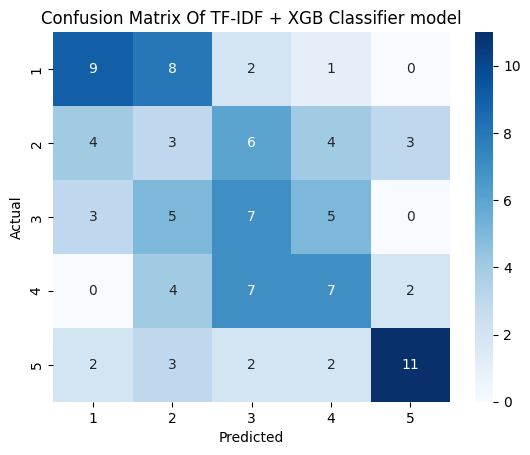

In [118]:


sns.heatmap(
    tfIDF_XGBC_cm,
    cmap= "Blues",
    annot= True,
    fmt= "g",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Of TF-IDF + XGB Classifier model")

plt.show()

###### <h6 style="font-size:1.1rem">Model Parameters</b>

In [119]:
tfIDF_XGBC_model_result.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__objective': 'multi:softprob',
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__device': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__feature_types': None,
 'estimator__feature_weights': None,
 'estimator__gamma': None,
 'estimator__grow_policy': None,
 'estimator__importance_type': 'gain',
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_bin': None,
 'estimator__max_cat_threshold': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimat

##### Word2Vec + XGBClassifier

###### <h6 style="font-size:1.1rem"> Train the model</b>

In [120]:
print(f"x_train_w2v shape: {X_train_w2v.shape}")
print(f"y_train shape: {y_train.shape}")

x_train_w2v shape: (809, 100)
y_train shape: (809,)


In [121]:
w2v_XGBC_model_result = xgbClassifier_model_grid.fit(X_train_w2v, y_train)

print("Training w2v_XGBC Model Done")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=100; total time=   3.0s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=100; total time=   3.1s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=100; total time=   5.6s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=200; total time=   5.5s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=200; total time=   7.9s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=200; total time=   5.4s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=300; total time=  10.0s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=300; total time=   9.6s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=8, n_estimators=300; total time=   7.1s
[CV] END booster=gbtree, learning_rate=0.025, max_depth=16, n_estimators=1

###### <h6 style="font-size:1.1rem"> Evaluate and cache the model</b>

In [122]:
model_path = os.path.join(project_path,"models/w2v_XGBC_model_result.pkl")
# Make sure the folder exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Evaluate new model
w2v_XGBC_prediction = w2v_XGBC_model_result.predict(X_test_w2v)
new_f1 = f1_score(y_test, w2v_XGBC_prediction, average="weighted")  # weighted average since each class maybe not sampled when splitting

# Check if previous model exists
if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        old_model = joblib.load(f)

    old_prediction = old_model.predict(X_test_w2v)
    old_f1 = f1_score(y_test, old_prediction, average="weighted")

    print(f"Old F1: {old_f1:.4f} | New F1: {new_f1:.4f}")

    if new_f1 > old_f1:
        print("🔁 New model is better — overwriting saved model.")
        with open(model_path, "wb") as f:
            joblib.dump(w2v_XGBC_model_result, f)
    else:
        print("✅ Existing model is still better.")
        w2v_XGBC_model_result = old_model
else:
    # No model saved yet
    print("📥 No existing model — saving new model.")
    with open(model_path, "wb") as f:
        joblib.dump(w2v_XGBC_model_result, f)


Old F1: 0.3144 | New F1: 0.3035
✅ Existing model is still better.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


###### <h6 style="font-size:1.1rem">Classification Report</b>

In [123]:
w2v_XGBC_prediction = w2v_XGBC_model_result.predict(X_test_w2v)

In [124]:
w2v_XGBC_predicted = ordinal_encoder.inverse_transform(w2v_XGBC_prediction.reshape(-1,1)).ravel()
actual_class = ordinal_encoder.inverse_transform(y_test.reshape(-1,1)).ravel()

class_names = sorted(pd.unique(actual_class))

In [125]:
print(classification_report(y_test, w2v_XGBC_predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.19      0.15      0.17        20
           2       0.28      0.25      0.26        20
           3       0.19      0.20      0.20        20
           4       0.15      0.20      0.17        20
           5       0.00      0.00      0.00         0

    accuracy                           0.16       100
   macro avg       0.13      0.13      0.13       100
weighted avg       0.16      0.16      0.16       100



###### <h6 style="font-size:1.1rem">Confusion Matrix</b>

In [126]:
w2v_XGBC_cm = pd.DataFrame(confusion_matrix(actual_class,
                         w2v_XGBC_predicted,
                         labels=class_names))
print("Word2Vec + XGB Confusion matrix")
print(w2v_XGBC_cm)

Word2Vec + XGB Confusion matrix
   0  1  2   3  4
0  5  6  3   4  2
1  3  4  7   3  3
2  4  5  4   4  3
3  0  2  4  11  3
4  4  1  3   4  8


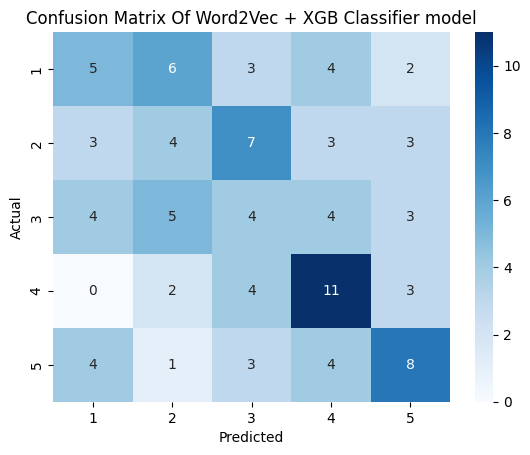

In [127]:


sns.heatmap(
    w2v_XGBC_cm,
    cmap= "Blues",
    annot= True,
    fmt= "g",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Of Word2Vec + XGB Classifier model")

plt.show()

###### <h6 style="font-size:1.1rem">Model Parameters</b>

In [128]:
w2v_XGBC_model_result.get_params()

{'cv': 2,
 'error_score': nan,
 'estimator__objective': 'multi:softprob',
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__device': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__feature_types': None,
 'estimator__feature_weights': None,
 'estimator__gamma': None,
 'estimator__grow_policy': None,
 'estimator__importance_type': 'gain',
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_bin': None,
 'estimator__max_cat_threshold': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimat

### LSTM Model

#### Hyper Parameter Tuning Setup

###### <h6 style="font-size:1.1rem"> Model Builder Function</b>

In [129]:
def define_model(trial, input_size, n_output):
    class GridLSTM(nn.Module):
        def __init__(self, trial, input_size: int, hidden_size: int, num_layers: int, n_output: int):
            super().__init__()

            def dense_layer_builder(layer_prefix):
                nonlocal input_size, dense_layers

                # Dense layer parameters
                out_size = trial.suggest_int(f"{layer_prefix}_output_size", 32, 256)
                dense_layers.append(nn.Linear(input_size, out_size))

                # Add drop out rate so that it reduces overfitting and improve generlization
                dropout_rate = trial.suggest_float(f"{layer_prefix}_dropout_rate", 0.0, 0.5)
                if dropout_rate > 0:
                    dense_layers.append(nn.Dropout(dropout_rate)) # Update input size for the next dense layer based on the output size of this one

                input_size = out_size

            if num_layers >= 3:
                lstm_dropout = trial.suggest_float("lstm_dropout", 0.0, 0.5)
            else:
                lstm_dropout = 0
                trial.set_user_attr("lstm_dropout", lstm_dropout)

            self.hidden_size = hidden_size
            self.num_layers = num_layers

            self.lstm = nn.LSTM(
                input_size = input_size,
                hidden_size = hidden_size, #number of LSTM Blocks
                num_layers = num_layers, #number of LSTM layers
                batch_first = True, # so that pytorch recognizes the input to be [batch_size, sequence_length, input_size] otherwise [sequence_length, batch_size, input_size]
                dropout = lstm_dropout
            )

            # Make the dense layers
            dense_layers = []
            input_size = hidden_size
            n_dense_layers = trial.suggest_int("n_dense_layer", 1, 10)

            for i in range(n_dense_layers):
                dense_layer_builder(f"dense_{i}") #input size would be updated each iteration

            #output Layer
            dense_layers.append(nn.Linear(input_size, n_output))  # No activation function here because nn.CrossEntropyLoss() already applies LogSoftmax internally

            # Register dense layers as nn.Sequential
            self.dense = nn.Sequential(*dense_layers)

        def forward(self, input_tensor): # Forward pass
            if input_tensor.dim() == 2:  # [seq_len, input_size] unbatched
                input_tensor = input_tensor.unsqueeze(1)  # make [1, seq_len, input_size] if the dimensions
                batch_size = input_tensor.size(0)
                h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
                c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

            else:  # [batch_size, seq_len, input_size]
                batch_size = input_tensor.size(0)
                h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
                c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

            out, _ = self.lstm(input_tensor, (h0, c0))  # LSTM forward
            out = self.dense(out[:, -1, :])             # Take last time step and pass through dense
            return out

    hidden_size = trial.suggest_int("lstm_hidden_size", 8, 128)
    num_layers = trial.suggest_int("lstm_num_layers", 1, 20)
    return GridLSTM(trial, input_size, hidden_size, num_layers, n_output)

###### <h6 style="font-size:1.1rem"> Set Optuna Objective</b>

In [130]:
# set the seed to 42
SEED = 42

def objective(trial, n_input, n_output, train_loader, val_loader, epochs, device):
    # Reset the seed for each trial of the gridsearch
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Parameters for early stopping
    best_f1 = 0 # Inital f1 score
    patience = 3 # number of epochs to wait without improvement before stopping
    epochs_no_improve = 0 # Epochs counter without improvement
    best_model_state = None # To store the best model weights

    # Model Initialization
    model = define_model(trial, n_input, n_output).to(device)

    # Learning rate
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)  # log-scale search

    # Optimizer Set-Up
    optimizer_name = trial.suggest_categorical("Optimizer", ["Adam", "Momentum", "AdamW"])
    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=lr),
        "Momentum": optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=trial.suggest_float("sgd_momentum", 1e-5, 1, log=True)),
        "AdamW": optim.AdamW(model.parameters(),
                            lr=lr,
                            weight_decay=trial.suggest_float("adamw_weight_decay", 1e-5, 1, log=True))
    }[optimizer_name]

    # Loss function
    loss_function = nn.CrossEntropyLoss() # Multi-class classification loss function

    for epoch in tqdm(range(epochs), desc="Training model..."):
        # Training loop
        model.train()
        for inputs, true_values in train_loader:
            inputs, true_values = inputs.to(device), true_values.to(device) # Set the device to train on

            optimizer.zero_grad() # Resets all the gradients since pytorch accumulates gradients from previous training
            outputs = model(inputs) # Runs a forward pass
            loss = loss_function(outputs, true_values) # Calculates the error
            loss.backward() # Runs a Backward pass
            optimizer.step() # Updates model trainable parameters

        # Early Stopping Check
        # Validation (after training loop finishes)
        model.eval() # Make model in evaluation mode
        all_preds = [] # For the model predictions and true lables
        all_labels = []

        with torch.no_grad(): # Turns off gradient tracking for speeding up validation, saves memory, lock memory weights
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device) # move lables to the device
                outputs = model(inputs) # Pass input data to the model to get raw logits
                _, predicted = torch.max(outputs, 1) # gets the predicted values. Since torch.max outputs max_values(confidence), and predictions

                all_preds.extend(predicted.cpu().numpy()) # move the predictions and lables to the cpu since numpy only works on CPU memory. then convert to numpy arrays then append to the list.
                all_labels.extend(labels.cpu().numpy())

        # Calculate F1 Score
        f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0) # Calculate f1 score weighted since there are class imbalances

        if f1 > best_f1:
            best_f1 = f1
            epochs_no_improve = 0
            best_model_state = deepcopy(model.state_dict()) # Save the model state
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                tqdm.write(f"Early stopping at epoch {epoch}")
                break

    # Load best model weights for reporting
    model.load_state_dict(best_model_state)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted")
    tqdm.write(f"Trial {trial.number}: Best F1 Score = {f1:.4f}")
    trial.set_user_attr("best_model_state", best_model_state)
    return f1

###### <h6 style="font-size:1.1rem"> Model Evaluation Functions</b>

In [131]:
# Model Builder from Parameters
def define_model_from_params(params: dict, input_size: int, n_output: int):
    class GridLSTM(nn.Module):
        def __init__(self):
            super().__init__()

            self.hidden_size = params["lstm_hidden_size"]
            self.num_layers = params["lstm_num_layers"]
            self.lstm_dropout = params.get("lstm_dropout", 0.0)

            self.lstm = nn.LSTM(
                input_size=input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True,
                dropout=self.lstm_dropout
            )

            # Build dense layers
            dense_layers = []
            dense_input_size = self.lstm.hidden_size
            n_dense_layers = params.get("n_dense_layer", 1)

            for i in range(n_dense_layers):
                out_size = params[f"dense_{i}_output_size"]
                dense_layers.append(nn.Linear(dense_input_size, out_size))

                dropout_rate = params.get(f"dense_{i}_dropout_rate", 0.0)
                if dropout_rate > 0:
                    dense_layers.append(nn.Dropout(dropout_rate))

                dense_input_size = out_size

            # Output layer
            dense_layers.append(nn.Linear(dense_input_size, n_output))
            self.dense = nn.Sequential(*dense_layers)

        def forward(self, input_tensor):
            if input_tensor.dim() == 2:  # [batch_size, input_size]
                input_tensor = input_tensor.unsqueeze(1)  # make it [batch_size, seq_len=1, input_size]
            batch_size = input_tensor.size(0)

            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

            # LSTM Forward pass
            out, _ = self.lstm(input_tensor, (h0, c0)) # out: [batch_size, seq_len, hidden_size]
            out = self.dense(out[:, -1, :]) # take the last time step and pass it to the dense layer
            return out

    return GridLSTM()

In [132]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)

    # classification report
    class_report = classification_report(all_labels, all_preds, zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[1,2,3,4,5])
    return f1, recall, precision, class_report, cm


#### TF-IDF + LSTM

###### <h6 style="font-size:1.1rem"> Pytorch Data Loader</b>

In [133]:
batch_size = 32

# Train data
x_train_tfidf_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
train_tfidf_dataset = TensorDataset(x_train_tfidf_tensor, y_train_tensor)
train_tfidf_loader = DataLoader(train_tfidf_dataset, batch_size=batch_size, shuffle=True)

# test data
x_test_tfidf_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_tfidf_dataset = TensorDataset(x_test_tfidf_tensor, y_test_tensor)
test_tfidf_loader = DataLoader(test_tfidf_dataset, batch_size=batch_size, shuffle=False)

# val data
x_val_tfidf_tensor = torch.tensor(X_val_tfidf.toarray(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
val_tfidf_dataset = TensorDataset(x_val_tfidf_tensor, y_val_tensor)
val_tfidf_loader = DataLoader(val_tfidf_dataset, batch_size=batch_size, shuffle=False)

##### Initiate Hyperparameter Tuning

In [134]:
# The input size
input_size = X_train_tfidf.toarray().shape[1]

# Get number of outputs
output_size = len(np.unique(y_train))
epochs = 50
n_trials = 500

samplers = optuna.samplers.TPESampler(n_startup_trials=20) # Bayesian optimization method used by Optuna to sample hyperparameters intelligently (20 random trials first before starting the Bayesian optimization.)
tfidf_study = optuna.create_study(direction="maximize", sampler=samplers) # Maximize f1 score

# Tqdm for cleaner output
progress_bar = tqdm(total=n_trials, desc="Trial", ncols=80)

for _ in tqdm(range(n_trials), desc="Gridsearch ..."):
    time.sleep(0.8) #wait for .8 seconds befor clearing the output
    clear_output(wait=True) # comment this out of you want to see the whole training process
    tfidf_study.optimize(lambda trial: objective(trial,input_size, output_size, train_tfidf_loader,
                                            val_tfidf_loader, epochs, device),
                    n_trials=1)

# Summarize tfidf_study results
pruned_trials = tfidf_study.get_trials(deepcopy=False, states=[TrialState.PRUNED]) # get the pruned trials
complete_trials = tfidf_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE]) # get the succeeded trials

print("\ntfidf_study statistics:")
print(f"  Finished trials: {len(tfidf_study.trials)}")
print(f"  Pruned trials:   {len(pruned_trials)}")
print(f"  Complete trials: {len(complete_trials)}")

# Define model with best params
tfidf_best_trial = tfidf_study.best_trial
print("Best trial:")
print(f"  F1 Score: {tfidf_best_trial.value:.4f}")
best_tfidf_model = define_model(tfidf_best_trial, input_size, output_size).to(device)
print("Best hyperparameters:")
for key, value in tfidf_best_trial.params.items():
    print(f"  {key}: {value}")

# Load best weights
best_tfidf_model.load_state_dict(tfidf_best_trial.user_attrs["best_model_state"])



Training model...:   0%|          | 0/50 [00:00<?, ?it/s]

Training model...:   2%|▏         | 1/50 [00:00<00:06,  8.07it/s]

Training model...:   4%|▍         | 2/50 [00:00<00:05,  8.44it/s]

Training model...:   6%|▌         | 3/50 [00:00<00:05,  8.45it/s]

Training model...:   8%|▊         | 4/50 [00:00<00:05,  8.40it/s]

Training model...:  10%|█         | 5/50 [00:00<00:05,  8.52it/s]

Training model...:  12%|█▏        | 6/50 [00:00<00:05,  8.32it/s]

Training model...:  14%|█▍        | 7/50 [00:00<00:05,  8.28it/s]




Training model...:  14%|█▍        | 7/50 [00:00<00:05,  7.28it/s]

Gridsearch ...: 100%|█████████▉| 499/500 [16:05<00:01,  1.93s/it][I 2025-11-07 23:21:03,905] Trial 499 finished with value: 0.34149144573592793 and parameters: {'lstm_hidden_size': 113, 'lstm_num_layers': 1, 'n_dense_layer': 7, 'dense_0_output_size': 93, 'dense_0_dropout_rate': 0.1863517009882751, 'dense_1_output_size': 94, 'dense_1_dropout_rate': 0.08870673463311045, 'dense_2_output_size': 199, '

Early stopping at epoch 7
Trial 499: Best F1 Score = 0.3415

tfidf_study statistics:
  Finished trials: 500
  Pruned trials:   0
  Complete trials: 500
Best trial:
  F1 Score: 0.4022
Best hyperparameters:
  lstm_hidden_size: 112
  lstm_num_layers: 1
  n_dense_layer: 6
  dense_0_output_size: 50
  dense_0_dropout_rate: 0.44606836810067224
  dense_1_output_size: 93
  dense_1_dropout_rate: 0.1882678672714814
  dense_2_output_size: 201
  dense_2_dropout_rate: 0.05511426560303583
  dense_3_output_size: 53
  dense_3_dropout_rate: 0.2241162689723429
  dense_4_output_size: 40
  dense_4_dropout_rate: 0.19358158955618884
  dense_5_output_size: 181
  dense_5_dropout_rate: 0.32992708894352896
  learning_rate: 0.002167057976242666
  Optimizer: AdamW
  sgd_momentum: 3.761445373216286e-05
  adamw_weight_decay: 0.41909720481503


<All keys matched successfully>

In [135]:
print("Best trial:")

print(f"  Value (f1 score): {tfidf_best_trial.value}")
print("  Params:")
for key, value in tfidf_best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (f1 score): 0.40221912436922574
  Params:
    lstm_hidden_size: 112
    lstm_num_layers: 1
    n_dense_layer: 6
    dense_0_output_size: 50
    dense_0_dropout_rate: 0.44606836810067224
    dense_1_output_size: 93
    dense_1_dropout_rate: 0.1882678672714814
    dense_2_output_size: 201
    dense_2_dropout_rate: 0.05511426560303583
    dense_3_output_size: 53
    dense_3_dropout_rate: 0.2241162689723429
    dense_4_output_size: 40
    dense_4_dropout_rate: 0.19358158955618884
    dense_5_output_size: 181
    dense_5_dropout_rate: 0.32992708894352896
    learning_rate: 0.002167057976242666
    Optimizer: AdamW
    sgd_momentum: 3.761445373216286e-05
    adamw_weight_decay: 0.41909720481503


##### Model Evaluation

###### <h6 style="font-size:1.1rem"> Model Scores</b>

In [136]:
tfidf_model_pytorch_path = os.path.join(project_path,"models/best_tfidf_model.pt")
tfidf_model_json_path = os.path.join(project_path,"models/best_tfidf_model.json")
new_tfidf_model = best_tfidf_model.to(device)
new_tfidf_model.eval()

# Evaluate new model on test set
new_f1, new_recall, new_precision, new_class_report, new_cm = evaluate_model(
                                                    new_tfidf_model,
                                                    test_tfidf_loader,
                                                    device
                                                    )

if os.path.exists(tfidf_model_pytorch_path) and os.path.exists(tfidf_model_json_path):
    # Load the existing (old) model
    with open(tfidf_model_json_path, "r") as f:
        best_tfidf_params = json.load(f)

    old_tfidf_model = define_model_from_params(best_tfidf_params, input_size, output_size).to(device)
    old_tfidf_model.load_state_dict(torch.load(tfidf_model_pytorch_path))
    old_tfidf_model.eval()

    # Evaluate the old model
    old_f1, old_recall, old_precision, old_class_report, old_cm = evaluate_model(
        old_tfidf_model,
        test_tfidf_loader,
        device
    )
    print("Model Scores:")
    print(f"Old_f1          = {old_f1:.4f}          | New_f1        = {new_f1:.4f}")
    print(f"Old_recall      = {old_recall:.4f}          | New_recall    = {new_recall:.4f}")
    print(f"Old_precision   = {old_precision:.4f}          | New_precision = {new_precision:.4f}")
    print()
    print("Old Cllassification Report:")
    print(old_class_report)
    print()
    print("New Cllassification Report:")
    print(new_class_report)

    if new_f1 > old_f1:
        print("🔁 New model is better — overwriting saved model.")
        torch.save(new_tfidf_model.state_dict(), tfidf_model_pytorch_path)
        with open(tfidf_model_json_path, "w") as f:
            json.dump(tfidf_best_trial.params, f, indent=4)
        tfidf_model = new_tfidf_model
    else:
        print("✅ Existing model is still better.")
        tfidf_model = old_tfidf_model
else:
    print("📥 No existing model — saving new model.")
    os.makedirs("./models", exist_ok=True)
    torch.save(new_tfidf_model.state_dict(), tfidf_model_pytorch_path)
    with open(tfidf_model_json_path, "w") as f:
        json.dump(tfidf_best_trial.params, f, indent=4)
    tfidf_model = new_tfidf_model

Model Scores:
Old_f1          = 0.3648          | New_f1        = 0.3659
Old_recall      = 0.3700          | New_recall    = 0.3800
Old_precision   = 0.3955          | New_precision = 0.3666

Old Cllassification Report:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33        20
           1       0.20      0.30      0.24        20
           2       0.46      0.30      0.36        20
           3       0.33      0.30      0.32        20
           4       0.48      0.70      0.57        20

    accuracy                           0.37       100
   macro avg       0.40      0.37      0.36       100
weighted avg       0.40      0.37      0.36       100


New Cllassification Report:
              precision    recall  f1-score   support

           0       0.42      0.65      0.51        20
           1       0.17      0.10      0.12        20
           2       0.20      0.20      0.20        20
           3       0.40      0.40      0.40  

###### <h6 style="font-size:1.1rem"> Confusion Matrix</b>

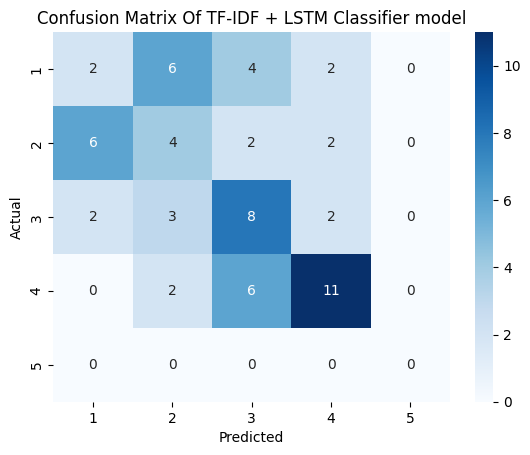

In [137]:
_, _, _, _, tfidf_cm = evaluate_model(
                                                    tfidf_model,
                                                    test_tfidf_loader,
                                                    device
                                                    )

sns.heatmap(
    new_cm,
    cmap= "Blues",
    annot= True,
    fmt= "g",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Of TF-IDF + LSTM Classifier model")

plt.show()

#### Word2Vec + LSTM

##### Pytorch Data Loader

In [138]:
batch_size = 32

# Train data
x_train_w2v_tensor = torch.tensor(X_train_w2v, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
train_w2v_dataset = TensorDataset(x_train_w2v_tensor, y_train_tensor)
train_w2v_loader = DataLoader(train_w2v_dataset, batch_size=batch_size, shuffle=True)

# test data
x_test_w2v_tensor = torch.tensor(X_test_w2v, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_w2v_dataset = TensorDataset(x_test_w2v_tensor, y_test_tensor)
test_w2v_loader = DataLoader(test_w2v_dataset, batch_size=batch_size, shuffle=False)

# val data
x_val_w2v_tensor = torch.tensor(X_val_w2v, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
val_w2v_dataset = TensorDataset(x_val_w2v_tensor, y_val_tensor)
val_w2v_loader = DataLoader(val_w2v_dataset, batch_size=batch_size, shuffle=False)

##### Initiate Hyperparameter Tuning

In [139]:
# The input size
input_size = X_train_w2v.shape[1]

# Get number of outputs
output_size = len(np.unique(y_train))
epochs = 50
n_trials = 500

samplers = optuna.samplers.TPESampler(n_startup_trials=20) # Bayesian optimization method used by Optuna to sample hyperparameters intelligently (20 random trials first before starting the Bayesian optimization.)
w2v_study = optuna.create_study(direction="maximize", sampler=samplers) # Maximize f1 score

# Tqdm for cleaner output
progress_bar = tqdm(total=n_trials, desc="Trial", ncols=80)

for _ in tqdm(range(n_trials), desc="Gridsearch ..."):
    time.sleep(0.8) #wait for .8 seconds befor clearing the output
    clear_output(wait=True) # comment this out of you want to see the whole training process
    w2v_study.optimize(lambda trial: objective(trial,input_size, output_size, train_w2v_loader,
                                            val_w2v_loader, epochs, device),
                    n_trials=1)

# Summarize w2v_study results
pruned_trials = w2v_study.get_trials(deepcopy=False, states=[TrialState.PRUNED]) # get the pruned trials
complete_trials = w2v_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE]) # get the succeeded trials

print("\nw2v_study statistics:")
print(f"  Finished trials: {len(w2v_study.trials)}")
print(f"  Pruned trials:   {len(pruned_trials)}")
print(f"  Complete trials: {len(complete_trials)}")

# Define model with best params
w2v_best_trial = w2v_study.best_trial
print("Best trial:")
print(f"  F1 Score: {w2v_best_trial.value:.4f}")
best_w2v_model = define_model(w2v_best_trial, input_size, output_size).to(device)
print("Best hyperparameters:")
for key, value in w2v_best_trial.params.items():
    print(f"  {key}: {value}")

# Load best weights
best_w2v_model.load_state_dict(w2v_best_trial.user_attrs["best_model_state"])



Training model...:   0%|          | 0/50 [00:00<?, ?it/s]

Training model...:   4%|▍         | 2/50 [00:00<00:04, 11.57it/s]

Training model...:   8%|▊         | 4/50 [00:00<00:03, 11.78it/s]

Training model...:  12%|█▏        | 6/50 [00:00<00:03, 11.61it/s]

Training model...:  16%|█▌        | 8/50 [00:00<00:03, 11.79it/s]




Training model...:  16%|█▌        | 8/50 [00:00<00:04, 10.32it/s]

Gridsearch ...: 100%|██████████| 500/500 [14:46<00:00,  1.77s/it]


Early stopping at epoch 8
Trial 499: Best F1 Score = 0.2226

w2v_study statistics:
  Finished trials: 500
  Pruned trials:   0
  Complete trials: 500
Best trial:
  F1 Score: 0.4193
Best hyperparameters:
  lstm_hidden_size: 70
  lstm_num_layers: 2
  n_dense_layer: 1
  dense_0_output_size: 155
  dense_0_dropout_rate: 0.21297926165599604
  learning_rate: 0.021700529253845524
  Optimizer: Adam
  sgd_momentum: 0.010159449765779226
  adamw_weight_decay: 0.0011423051015030234


<All keys matched successfully>

In [140]:
print("Best trial:")

print(f"  Value (f1 score): {w2v_best_trial.value}")
print("  Params:")
for key, value in w2v_best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (f1 score): 0.4192585536238787
  Params:
    lstm_hidden_size: 70
    lstm_num_layers: 2
    n_dense_layer: 1
    dense_0_output_size: 155
    dense_0_dropout_rate: 0.21297926165599604
    learning_rate: 0.021700529253845524
    Optimizer: Adam
    sgd_momentum: 0.010159449765779226
    adamw_weight_decay: 0.0011423051015030234


##### Model Evaluation

###### <h6 style="font-size:1.1rem">Model Scores</b>

In [141]:
w2v_model_pytorch_path = os.path.join(project_path,"models/best_w2v_model.pt")
w2v_model_json_path = os.path.join(project_path,"models/best_w2v_model.json")
new_w2v_model = best_w2v_model.to(device)
new_w2v_model.eval()

# Evaluate new model on test set
new_f1, new_recall, new_precision, new_class_report, new_cm = evaluate_model(
                                                    new_w2v_model,
                                                    test_w2v_loader,
                                                    device
                                                    )

if os.path.exists(w2v_model_pytorch_path) and os.path.exists(w2v_model_json_path):
    # Load the existing (old) model
    with open(w2v_model_json_path, "r") as f:
        best_w2v_params = json.load(f)

    old_w2v_model = define_model_from_params(best_w2v_params, input_size, output_size).to(device)
    old_w2v_model.load_state_dict(torch.load(w2v_model_pytorch_path))
    old_w2v_model.eval()

    # Evaluate the old model
    old_f1, old_recall, old_precision, old_class_report, old_cm = evaluate_model(
        old_w2v_model,
        test_w2v_loader,
        device
    )
    print("Model Scores:")
    print(f"Old_f1          = {old_f1:.4f}          | New_f1        = {new_f1:.4f}")
    print(f"Old_recall      = {old_recall:.4f}          | New_recall    = {new_recall:.4f}")
    print(f"Old_precision   = {old_precision:.4f}          | New_precision = {new_precision:.4f}")
    print()
    print("Old Cllassification Report:")
    print(old_class_report)
    print()
    print("New Cllassification Report:")
    print(new_class_report)

    if new_f1 > old_f1:
        print("🔁 New model is better — overwriting saved model.")
        torch.save(new_w2v_model.state_dict(), w2v_model_pytorch_path)
        with open(w2v_model_json_path, "w") as f:
            json.dump(w2v_best_trial.params, f, indent=4)
        w2v_model = new_w2v_model
    else:
        print("✅ Existing model is still better.")
        w2v_model = old_w2v_model
else:
    print("📥 No existing model — saving new model.")
    os.makedirs("./models", exist_ok=True)
    torch.save(new_w2v_model.state_dict(), w2v_model_pytorch_path)
    with open(w2v_model_json_path, "w") as f:
        json.dump(w2v_best_trial.params, f, indent=4)
    w2v_model = new_w2v_model

Model Scores:
Old_f1          = 0.3240          | New_f1        = 0.2910
Old_recall      = 0.3300          | New_recall    = 0.3200
Old_precision   = 0.3980          | New_precision = 0.2707

Old Cllassification Report:
              precision    recall  f1-score   support

           0       0.80      0.20      0.32        20
           1       0.18      0.15      0.16        20
           2       0.19      0.25      0.22        20
           3       0.32      0.45      0.38        20
           4       0.50      0.60      0.55        20

    accuracy                           0.33       100
   macro avg       0.40      0.33      0.32       100
weighted avg       0.40      0.33      0.32       100


New Cllassification Report:
              precision    recall  f1-score   support

           0       0.47      0.45      0.46        20
           1       0.00      0.00      0.00        20
           2       0.18      0.25      0.21        20
           3       0.27      0.40      0.32  

###### <h6 style="font-size:1.1rem">Confusion Matrix</b>

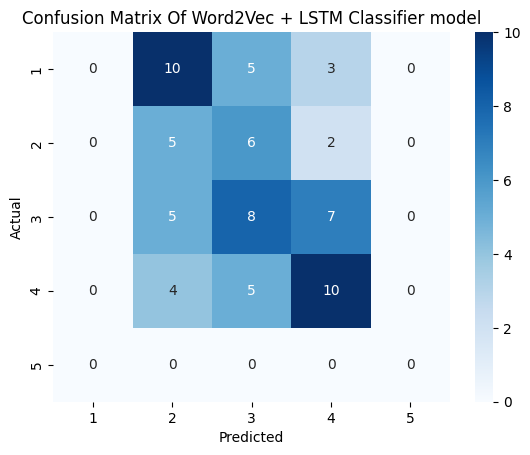

In [142]:
_, _, _, _, w2v_cm = evaluate_model(
                                                    w2v_model,
                                                    test_w2v_loader,
                                                    device
                                                    )

sns.heatmap(
    new_cm,
    cmap= "Blues",
    annot= True,
    fmt= "g",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Of Word2Vec + LSTM Classifier model")

plt.show()